In [1]:
from acquire import get_telco_data
from prepare import train_validate_test_split, prep_telco
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import explore
from scipy import stats

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = get_telco_data()

df = prep_telco(df)


Using cached data


In [3]:
train, validate, test = train_validate_test_split(df, target = 'churn', seed =123)

In [4]:
# Baseline churn rate
baseline_churn = (train.churn == 0).mean()

In [5]:
print(baseline_churn)

0.7343154686309372


In [6]:
train.columns

Index(['customer_id', 'is_senior_citizen', 'tenure', 'multiple_lines',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'paperless_billing',
       'monthly_charges', 'total_charges', 'churn', 'contract_type',
       'internet_service_type', 'payment_type', 'is_male', 'has_phone',
       'has_internet_service', 'has_partner', 'has_dependent', 'is_paperless',
       'is_month_to_month', 'is_autopay', 'has_streaming'],
      dtype='object')

In [7]:
selected_features = ['monthly_charges','is_autopay','has_internet_service','tenure','is_month_to_month','has_streaming','is_senior_citizen','is_paperless']
target = 'churn'

In [8]:
X_train = train[selected_features]
y_train = train[[target]]

X_validate = validate[selected_features]
y_validate = validate[[target]]

X_test = test[selected_features]
y_test = test[[target]]

# Decision Tree

In [9]:
def decision_tree_train(X_train, y_train, selected_features=selected_features, target=target, d = 10, m=1, print_results = True):
  
    clf = DecisionTreeClassifier(max_depth=d, min_samples_leaf = m, random_state=123)
    clf = clf.fit(X_train, y_train)
    accuracy = clf.score(X_train, y_train)
    y_pred = clf.predict(X_train)
    class_report = classification_report(y_train, y_pred,output_dict=True)
    
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
        
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    if print_results:
        print(f"TRAINING RESULTS: {type(clf).__name__}")
        print(f"Using features: {selected_features}")
        print(f"Depth of {clf.max_depth}")
        print(f"Min Sample Leaf of {clf.min_samples_leaf}")
        print("----------------")
        print(f"Accuracy score on training set is: {accuracy:.2f}")
        print(classification_report(y_train, y_pred))


        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    
    train_report = {'d':clf.max_depth, 
                    'm':clf.min_samples_leaf,
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return clf, train_report

def classifier_validate(X_validate, y_validate, clf, print_results=True):
    d = clf.max_depth
    accuracy = clf.score(X_validate, y_validate)


    # Produce y_predictions that come from the X_validate
    y_pred = clf.predict(X_validate)
    
    class_report = classification_report(y_validate, y_pred,output_dict=True)
    tn, fp, fn, tp = confusion_matrix(y_validate, y_pred).ravel()
    
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    # Compare actual y values (from validate) to predicted y_values from the model run on X_validate
    if print_results:
        print(f"-----VALIDATE RESULTS: {type(clf).__name__}-----")
        print(f"Using features: {selected_features}")
        print(f"Depth of {clf.max_depth}")
        print(f"Min Sample Leaf of {clf.min_samples_leaf}")
        print(classification_report(y_validate, y_pred))

        print(f'Accuracy on validate set: {accuracy:.2f}')
    validate_report = {'d':clf.max_depth, 
                       'm':clf.min_samples_leaf,
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return validate_report

In [10]:
depths =[]
min_samples = []
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []
min_samples_range = range(1,10)
d_range = range(1,10)
for d in d_range:
    for min_sample in min_samples_range:
        clf, train_report = decision_tree_train(X_train, y_train, d=d, m = min_sample , print_results=False)
        validate_report = classifier_validate(X_validate,y_validate, clf, print_results=False)

        depths.append(d)
        min_samples.append(min_sample)
        train_accuracies.append(train_report['accuracy'])
        train_precisions.append(train_report['precision'])
        train_recalls.append(train_report['recall'])

        v_accuracies.append(validate_report['accuracy'])
        v_precisions.append(validate_report['precision'])
        v_recalls.append(validate_report['recall'])

In [11]:
train_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['max_depth','min_samples_leaf'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train

combined_df = combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train:\n {combined_df.accuracy_train.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_train.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate:\n{combined_df.accuracy_validate.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_validate.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_validate.idxmax()]}")
print(f"This was a drop-off from train of:\n{combined_df.accuracy_diff[combined_df.accuracy_validate == combined_df.accuracy_validate.max()].array[0]}")
print(f"Lowest drop-off in accuracy from train to validate:\n {combined_df.accuracy_diff.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]} and min sample leaf of  {combined_df.min_samples_leaf[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]}")

decision_tree_final_results = combined_df
decision_tree_final_results["model"] = 'decision_tree'

Highest accuracy score on train:
 0.8407416814833629 with max depth setting of 9 and min_sample_leaf of 1
Highest accuracy score on validate:
0.7855450236966824 with max depth setting of 6 and min_sample_leaf of 6
This was a drop-off from train of:
-0.020652588698542362
Lowest drop-off in accuracy from train to validate:
 -0.00031072929444431185 with max depth setting of 1 and min sample leaf of  1


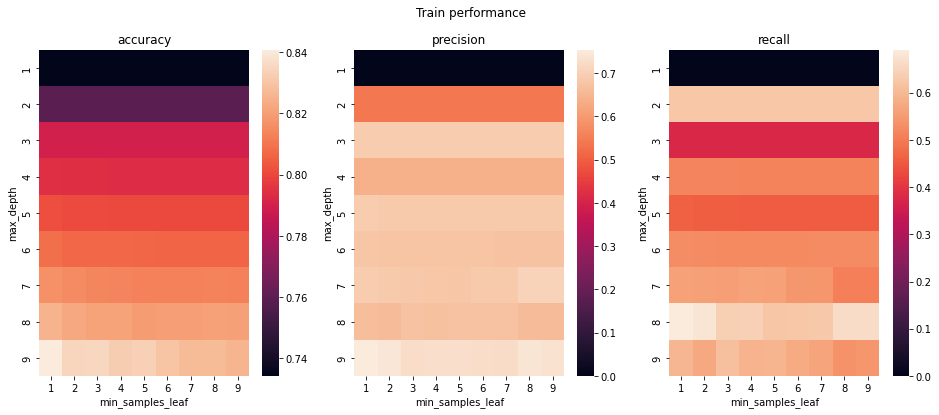

In [12]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    heatmap_df = train_results_df.pivot("max_depth","min_samples_leaf",metric)
    # Set floor of accuracy at the baseline 
    if i == 0:
        sns.heatmap(heatmap_df, ax=ax[i], vmin = baseline_churn)
        ax[i].set_title(metric)
    else:
        sns.heatmap(heatmap_df, ax=ax[i])
        ax[i].set_title(metric)
    plt.suptitle('Train performance')
    

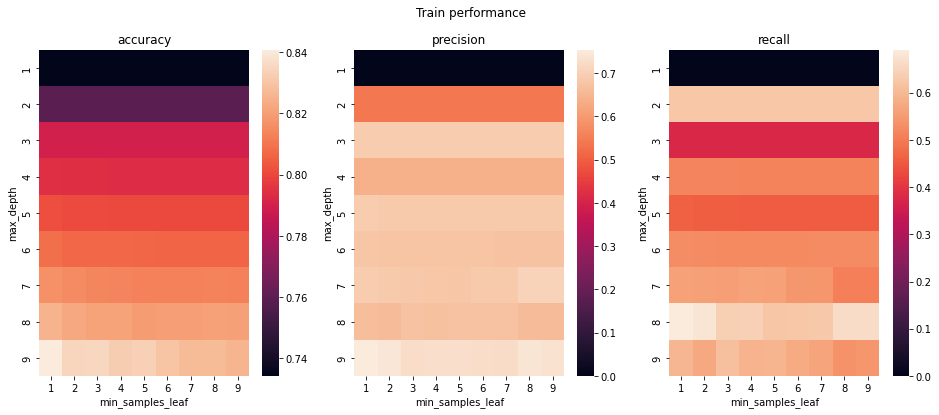

In [13]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    heatmap_df = train_results_df.pivot("max_depth","min_samples_leaf",metric)
    # Set floor of accuracy at the baseline 
    if i == 0:
        sns.heatmap(heatmap_df, ax=ax[i], vmin = baseline_churn)
        ax[i].set_title(metric)
    else:
        sns.heatmap(heatmap_df, ax=ax[i])
        ax[i].set_title(metric)
    plt.suptitle('Train performance')

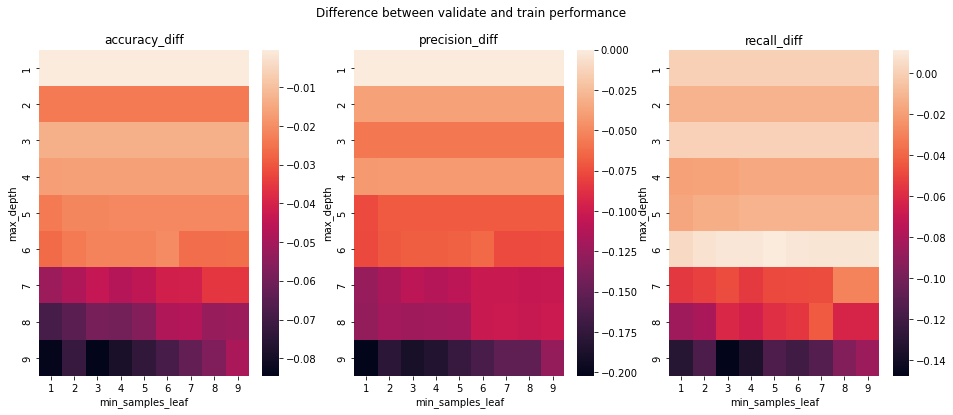

In [14]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy_diff","precision_diff","recall_diff"]
for i, metric in enumerate(to_plot):
    heatmap_df = combined_df.pivot("max_depth","min_samples_leaf",metric)
    sns.heatmap(heatmap_df, ax=ax[i])
    plt.suptitle('Difference between validate and train performance')
    ax[i].set_title(metric)

# Random Forest

In [15]:
def random_forest_train(X_train, y_train, selected_features=selected_features, target=target, d = 10, m=1, print_results = True):
  
    clf = RandomForestClassifier(max_depth=d, min_samples_leaf = m, random_state=123)
    clf = clf.fit(X_train, y_train)
    accuracy = clf.score(X_train, y_train)
    y_pred = clf.predict(X_train)
    class_report = classification_report(y_train, y_pred,output_dict=True)
    
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
        
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    if print_results:
        print(f"TRAINING RESULTS: {type(clf).__name__}")
        print(f"Using features: {selected_features}")
        print(f"Depth of {clf.max_depth}")
        print(f"Min Sample Leaf of {clf.min_samples_leaf}")
        print("----------------")
        print(classification_report(y_train, y_pred))


        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    
    train_report = {'d':clf.max_depth, 
                    'm':clf.min_samples_leaf,
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return clf, train_report

In [16]:
depths =[]
min_samples = []
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []
min_samples_range = range(1,10)
d_range = range(1,10)
for d in d_range:
    for min_sample in min_samples_range:
        clf, train_report = random_forest_train(X_train, y_train, d=d, m = min_sample , print_results=False)
        validate_report = classifier_validate(X_validate,y_validate, clf, print_results=False)

        depths.append(d)
        min_samples.append(min_sample)
        train_accuracies.append(train_report['accuracy'])
        train_precisions.append(train_report['precision'])
        train_recalls.append(train_report['recall'])

        v_accuracies.append(validate_report['accuracy'])
        v_precisions.append(validate_report['precision'])
        v_recalls.append(validate_report['recall'])

In [17]:
train_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"max_depth":depths,"min_samples_leaf":min_samples,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['max_depth','min_samples_leaf'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train

combined_df = combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train:\n {combined_df.accuracy_train.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_train.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate:\n{combined_df.accuracy_validate.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_validate.idxmax()]} and min_sample_leaf of {combined_df.min_samples_leaf[combined_df.accuracy_validate.idxmax()]}")
print(f"This was a drop-off from train of:\n{combined_df.accuracy_diff[combined_df.accuracy_validate == combined_df.accuracy_validate.max()].array[0]}")
print(f"Lowest drop-off in accuracy from train to validate:\n {combined_df.accuracy_diff.max()} with max depth setting of {combined_df.max_depth[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]} and min sample leaf of  {combined_df.min_samples_leaf[combined_df.accuracy_diff == combined_df.accuracy_diff.max()].array[0]}")

random_forest_final_results = combined_df
random_forest_final_results["model"] = 'random_forest'

Highest accuracy score on train:
 0.8597917195834391 with max depth setting of 9 and min_sample_leaf of 1
Highest accuracy score on validate:
0.792654028436019 with max depth setting of 6 and min_sample_leaf of 4
This was a drop-off from train of:
-0.019893596659231183
Lowest drop-off in accuracy from train to validate:
 -0.00031072929444431185 with max depth setting of 1 and min sample leaf of  1


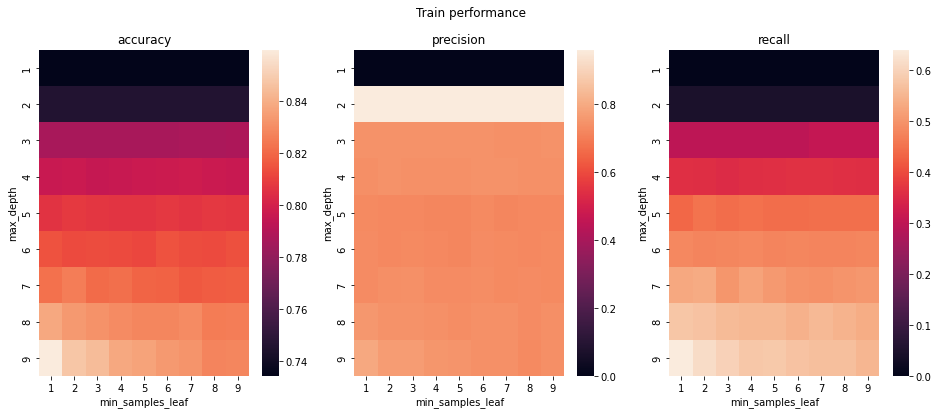

In [18]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
    
for i, metric in enumerate(to_plot):
    heatmap_df = train_results_df.pivot("max_depth","min_samples_leaf",metric)
    # Set floor of accuracy at the baseline 
    if i == 0:
        sns.heatmap(heatmap_df, ax=ax[i], vmin = baseline_churn)
        ax[i].set_title(metric)
    else:
        sns.heatmap(heatmap_df, ax=ax[i])
        ax[i].set_title(metric)
    plt.suptitle('Train performance')

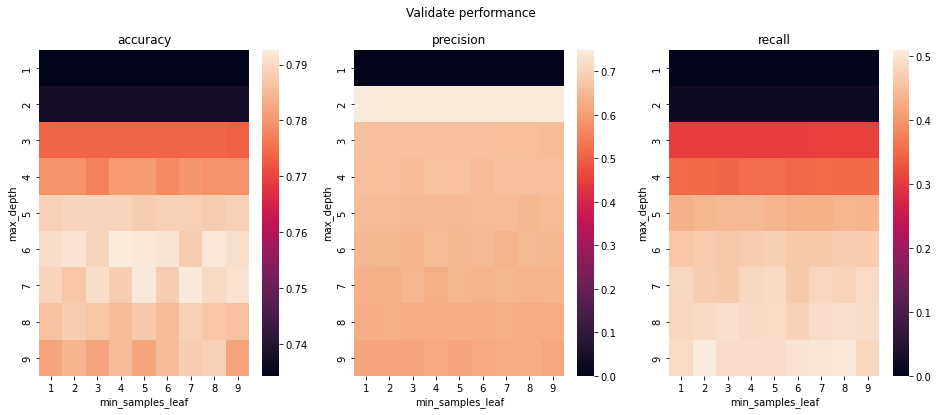

In [19]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    heatmap_df = validate_results_df.pivot("max_depth","min_samples_leaf",metric)
    # Set floor of accuracy at the baseline 
    if i == 0:
        sns.heatmap(heatmap_df, ax=ax[i], vmin = baseline_churn)
        ax[i].set_title(metric)
    else:
        sns.heatmap(heatmap_df, ax=ax[i])
        ax[i].set_title(metric)
    plt.suptitle('Validate performance')


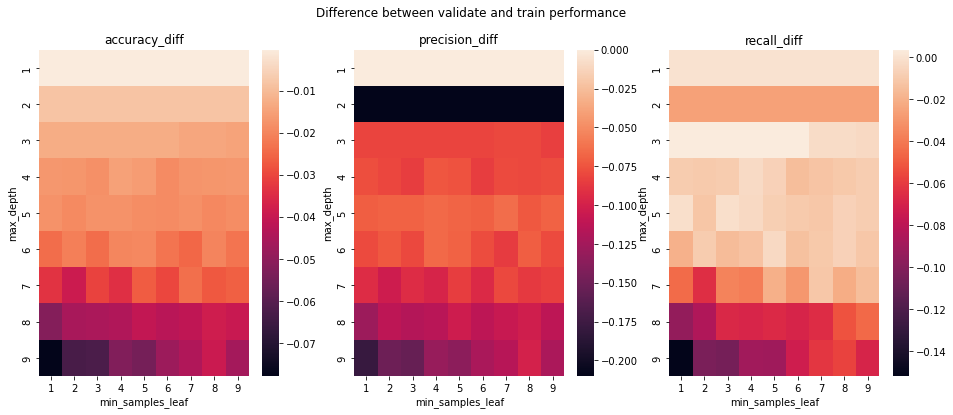

In [20]:
_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy_diff","precision_diff","recall_diff"]
for i, metric in enumerate(to_plot):
    heatmap_df = combined_df.pivot("max_depth","min_samples_leaf",metric)
    sns.heatmap(heatmap_df, ax=ax[i])
    plt.suptitle('Difference between validate and train performance')
    ax[i].set_title(metric)

# KNN

In [21]:
def knn_train(X_train, y_train, selected_features=selected_features, target=target, k=1, print_results = True):
  
    clf = KNeighborsClassifier(n_neighbors=k)
    clf = clf.fit(X_train, y_train)
    accuracy = clf.score(X_train, y_train)
    y_pred = clf.predict(X_train)
    class_report = classification_report(y_train, y_pred,output_dict=True)
    
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
        
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    if print_results:
        print(f"TRAINING RESULTS: {type(clf).__name__}")
        print(f"Using features: {selected_features}")
        print(f"K of {clf.n_neighbors}")
        print("----------------")
        print(classification_report(y_train, y_pred))


        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    
    train_report = {'k':clf.n_neighbors, 
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return clf, train_report

def knn_validate(X_validate, y_validate, clf, print_results=True):
    accuracy = clf.score(X_validate, y_validate)


    # Produce y_predictions that come from the X_validate
    y_pred = clf.predict(X_validate)
    
    class_report = classification_report(y_validate, y_pred,output_dict=True)
    tn, fp, fn, tp = confusion_matrix(y_validate, y_pred).ravel()
    
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    # Compare actual y values (from validate) to predicted y_values from the model run on X_validate
    if print_results:
        print(f"-----VALIDATE RESULTS: {type(clf).__name__}-----")
        print(f"Using features: {selected_features}")
        print(f"K of {clf.n_neighbors}")
        print(classification_report(y_validate, y_pred))

        print(f'Accuracy on validate set: {accuracy:.2f}')
    validate_report = {'k':clf.n_neighbors, 
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return validate_report

In [22]:
ks =[]
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []

k_range = range(1,100)
for k in k_range:

    clf, train_report = knn_train(X_train, y_train, k=k, print_results=False)
    validate_report = knn_validate(X_validate,y_validate, clf, print_results=False)

    ks.append(k)
    min_samples.append(min_sample)
    train_accuracies.append(train_report['accuracy'])
    train_precisions.append(train_report['precision'])
    train_recalls.append(train_report['recall'])

    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['precision'])
    v_recalls.append(validate_report['recall'])

In [23]:
train_results_df= pd.DataFrame(data = {"k":ks,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"k":ks,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['k'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train

combined_df = combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train:\n {combined_df.accuracy_train.max()} with k setting of {combined_df.k[combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate:\n {combined_df.accuracy_validate.max()} with k setting of {combined_df.k[combined_df.accuracy_validate.idxmax()]}")
print(f"Lowest drop-off in accuracy from train to validate:\n {combined_df.accuracy_diff.min()} with k setting of {combined_df.k[combined_df.accuracy_diff == combined_df.accuracy_diff.min()].array[0]}")

knn_final_results = combined_df
knn_final_results["model"] = 'k_nearest_neighbors'

Highest accuracy score on train:
 0.9923799847599695 with k setting of 1
Highest accuracy score on validate:
 0.7861374407582938 with k setting of 87
Lowest drop-off in accuracy from train to validate:
 -0.27614775727181784 with k setting of 1


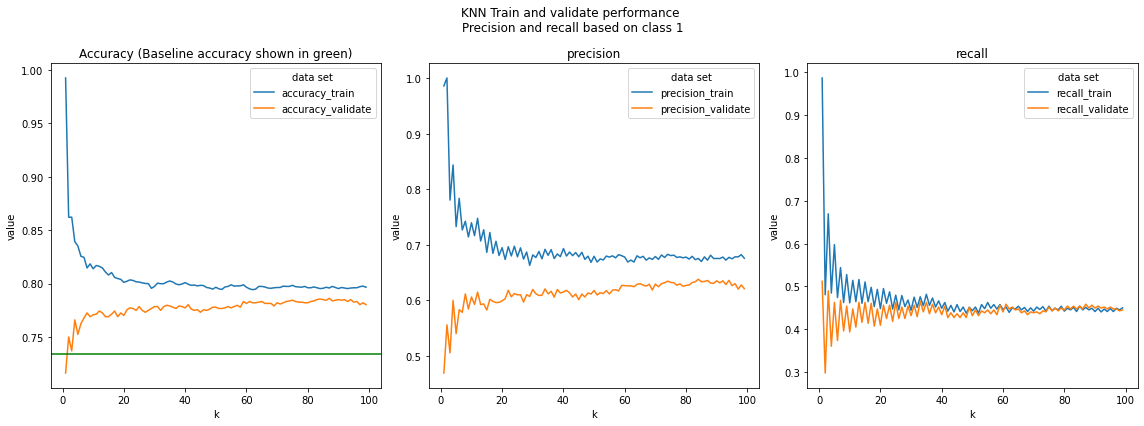

In [24]:

# Melt metrics into same column to enable clean plotting with seaborn
data = pd.melt(combined_df.drop(columns = ['accuracy_diff','precision_diff','recall_diff']), id_vars =['k'], var_name='metric')

_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    sns.lineplot(x = data[data.metric.str.contains(metric)].k, 
                 y = data[data.metric.str.contains(metric)].value, 
                 hue = data[data.metric.str.contains(metric)].metric,  
                 ax=ax[i])
    
    plt.suptitle(f'KNN Train and validate performance \nPrecision and recall based on class 1')
    plt.tight_layout()
    #plt.xticks([analysis_range])
    ax[i].legend(title = 'data set')
    ax[i].set_title(metric)
    if metric == "accuracy":
        ax[i].set_title('Accuracy (Baseline accuracy shown in green)')
        ax[i].axhline(baseline_churn, color = 'green')

# Logistic Regression

In [25]:
def logistic_regression_train(X_train, y_train, selected_features=selected_features, target=target, c=1, print_results = True):
  
    clf = LogisticRegression(C=c)
    clf = clf.fit(X_train, y_train)
    accuracy = clf.score(X_train, y_train)
    y_pred = clf.predict(X_train)
    class_report = classification_report(y_train, y_pred,output_dict=True)
    
    tn, fp, fn, tp = confusion_matrix(y_train, y_pred).ravel()
        
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    if print_results:
        print(f"TRAINING RESULTS: {type(clf).__name__}")
        print(f"Using features: {selected_features}")
        print(f"C of {clf.C}")
        print("----------------")
        print(classification_report(y_train, y_pred))


        print(f"False positive rate: {fp/(fp+tn):.2%}")
        print(f"False negative rate: {fn/(fn+tp):.2%}")
        print(f"True positive rate: {tp/(tp+fn):.2%}")
        print(f"True negative rate: {tn/(fp+tn):.2%}")
        print("----------------")
    
    train_report = {'c':clf.C, 
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return clf, train_report

def logisitic_regression_validate(X_validate, y_validate, clf, print_results=True):
    accuracy = clf.score(X_validate, y_validate)

    # Produce y_predictions that come from the X_validate
    y_pred = clf.predict(X_validate)
    
    class_report = classification_report(y_validate, y_pred,output_dict=True)
    tn, fp, fn, tp = confusion_matrix(y_validate, y_pred).ravel()
    
    fp_rate = fp/(fp+tn)
    fn_rate = fn/(fn+tp)
    tp_rate = tp/(tp+fn)
    tn_rate = tn/(fp+tn)
    # Compare actual y values (from validate) to predicted y_values from the model run on X_validate
    if print_results:
        print(f"-----VALIDATE RESULTS: {type(clf).__name__}-----")
        print(f"Using features: {selected_features}")
        print(f"C of {clf.C}")
        print(classification_report(y_validate, y_pred))

        print(f'Accuracy on validate set: {accuracy:.2f}')
    validate_report = {'c':clf.C, 
                    'accuracy':accuracy, 
                    'precision':class_report['1']['precision'], 
                    'recall':class_report['1']['recall'],
                   'fp_rate':fp_rate,
                   'fn_rate':fn_rate,
                   'tp_rate':tp_rate,
                   'tn_rate':tn_rate}
    
    return validate_report

In [26]:
cs =[]
train_accuracies = []
train_precisions = []
train_recalls = []

v_accuracies = []
v_precisions = []
v_recalls = []

c_range = np.linspace(0.01, 10000, num = 50)#[0.01, 0.1, 1.0, 10, 100, 1000, 10000]
for c in c_range:

    clf, train_report = logistic_regression_train(X_train, y_train, c=c, print_results=False)
    validate_report = logisitic_regression_validate(X_validate,y_validate, clf, print_results=False)

    cs.append(clf.C)
    min_samples.append(min_sample)
    train_accuracies.append(train_report['accuracy'])
    train_precisions.append(train_report['precision'])
    train_recalls.append(train_report['recall'])

    v_accuracies.append(validate_report['accuracy'])
    v_precisions.append(validate_report['precision'])
    v_recalls.append(validate_report['recall'])

In [27]:
train_results_df= pd.DataFrame(data = {"c":cs,"accuracy":train_accuracies,"precision":train_precisions,"recall":train_recalls})
validate_results_df= pd.DataFrame(data = {"c":cs,"accuracy":v_accuracies,"precision":v_precisions,"recall":v_recalls})

combined_df = train_results_df.merge(validate_results_df,on=['c'], suffixes=['_train','_validate'])
combined_df["accuracy_diff"] = combined_df.accuracy_validate-combined_df.accuracy_train
combined_df["precision_diff"] = combined_df.precision_validate-combined_df.precision_train
combined_df["recall_diff"] = combined_df.recall_validate-combined_df.recall_train

combined_df = combined_df.sort_values(by =['accuracy_validate','accuracy_diff'], ascending=False)
print(f"Highest accuracy score on train:\n {combined_df.accuracy_train.max()} with c setting of {combined_df.c[combined_df.accuracy_train.idxmax()]}")
print(f"Highest accuracy score on validate:\n {combined_df.accuracy_validate.max()} with c setting of {combined_df.c[combined_df.accuracy_validate.idxmax()]}")
print(f"Lowest drop-off in accuracy from train to validate:\n {combined_df.accuracy_diff.min()} with c setting of {combined_df.c[combined_df.accuracy_diff == combined_df.accuracy_diff.min()].array[0]}")

logistic_regression_final_results = combined_df
logistic_regression_final_results["model"] = 'logistic_regression'

Highest accuracy score on train:
 0.7950215900431801 with c setting of 0.01
Highest accuracy score on validate:
 0.7819905213270142 with c setting of 0.01
Lowest drop-off in accuracy from train to validate:
 -0.019292903514716908 with c setting of 7142.860000000001


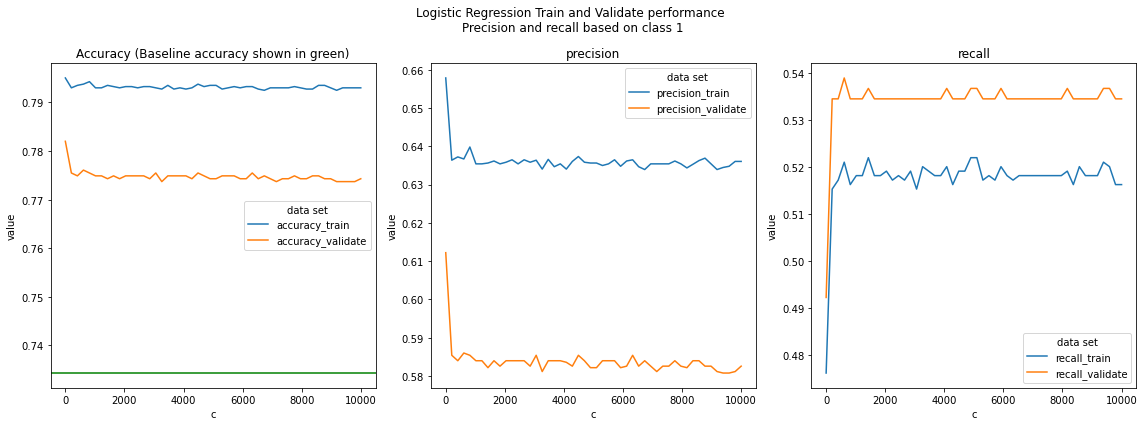

In [28]:

# Melt metrics into same column to enable clean plotting with seaborn
data = pd.melt(combined_df.drop(columns = ['accuracy_diff','precision_diff','recall_diff']), id_vars =['c'], var_name='metric')

_, ax = plt.subplots(1,3, figsize=(16,6))
to_plot = ["accuracy","precision","recall"]
for i, metric in enumerate(to_plot):
    sns.lineplot(x = data[data.metric.str.contains(metric)].c, 
                 y = data[data.metric.str.contains(metric)].value, 
                 hue = data[data.metric.str.contains(metric)].metric,  
                 ax=ax[i])
    
    plt.suptitle(f'Logistic Regression Train and Validate performance \nPrecision and recall based on class 1')
    plt.tight_layout()
    #plt.xticks([analysis_range])
    ax[i].legend(title = 'data set')
    ax[i].set_title(metric)
    if metric == "accuracy":
        ax[i].set_title('Accuracy (Baseline accuracy shown in green)')
        ax[i].axhline(baseline_churn, color = 'green')

In [29]:
final_results = pd.concat([decision_tree_final_results,random_forest_final_results,knn_final_results,logistic_regression_final_results])

In [32]:
final_results.sort_values(by='accuracy_validate', ascending=False)

,max_depth,min_samples_leaf,accuracy_train,precision_train,recall_train,accuracy_validate,precision_validate,recall_validate,accuracy_diff,precision_diff,recall_diff,model,k,c
48,6.0,4.0,0.812548,0.720630,0.480880,0.792654,0.654206,0.467706,-0.019894,-0.066425,-0.013174,random_forest,NaN,NaN
49,6.0,5.0,0.811532,0.719653,0.476099,0.792062,0.650307,0.472160,-0.019470,-0.069346,-0.003939,random_forest,NaN,NaN
52,6.0,8.0,0.812294,0.722142,0.477055,0.792062,0.651235,0.469933,-0.020232,-0.070907,-0.007122,random_forest,NaN,NaN
60,7.0,7.0,0.815850,0.726375,0.492352,0.792062,0.646707,0.481069,-0.023788,-0.079669,-0.011283,random_forest,NaN,NaN
58,7.0,5.0,0.818898,0.729655,0.505736,0.792062,0.644970,0.485523,-0.026836,-0.084685,-0.020213,random_forest,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,1.0,5.0,0.734315,0.000000,0.000000,0.734005,0.000000,0.000000,-0.000311,0.000000,0.000000,decision_tree,NaN,NaN
3,1.0,4.0,0.734315,0.000000,0.000000,0.734005,0.000000,0.000000,-0.000311,0.000000,0.000000,decision_tree,NaN,NaN
2,1.0,3.0,0.734315,0.000000,0.000000,0.734005,0.000000,0.000000,-0.000311,0.000000,0.000000,decision_tree,NaN,NaN
2,1.0,3.0,0.734315,0.000000,0.000000,0.734005,0.000000,0.000000,-0.000311,0.000000,0.000000,random_forest,NaN,NaN


## Based on test results, going with KNN of k = 87

In [35]:
clf, train_report = knn_train(X_train, y_train, selected_features, target, k=87, print_results=False)


In [37]:

accuracy = clf.score(X_validate, y_validate)


# Produce y_predictions that come from the X_validate
y_pred = clf.predict(X_validate)

class_report = classification_report(y_validate, y_pred,output_dict=True)
tn, fp, fn, tp = confusion_matrix(y_validate, y_pred).ravel()

fp_rate = fp/(fp+tn)
fn_rate = fn/(fn+tp)
tp_rate = tp/(tp+fn)
tn_rate = tn/(fp+tn)
# Compare actual y values (from validate) to predicted y_values from the model run on X_validate

print(f"-----VALIDATE RESULTS: {type(clf).__name__}-----")
print(f"Using features: {selected_features}")
print(f"K of {clf.n_neighbors}")
print(classification_report(y_validate, y_pred))

print(f'Accuracy on validate set: {accuracy:.2f}')
validate_report = {'k':clf.n_neighbors, 
            'accuracy':accuracy, 
            'precision':class_report['1']['precision'], 
            'recall':class_report['1']['recall'],
           'fp_rate':fp_rate,
           'fn_rate':fn_rate,
           'tp_rate':tp_rate,
           'tn_rate':tn_rate}



-----VALIDATE RESULTS: KNeighborsClassifier-----
Using features: ['monthly_charges', 'is_autopay', 'has_internet_service', 'tenure', 'is_month_to_month', 'has_streaming', 'is_senior_citizen', 'is_paperless']
K of 87
              precision    recall  f1-score   support

           0       0.82      0.90      0.86      1239
           1       0.64      0.46      0.53       449

    accuracy                           0.79      1688
   macro avg       0.73      0.68      0.70      1688
weighted avg       0.77      0.79      0.77      1688

Accuracy on validate set: 0.79


## Want a csv of predictions

In [39]:
clf

KNeighborsClassifier(n_neighbors=87)

In [52]:
y_pred_proba = clf.predict_proba(X_test)

In [53]:
# Want customer_id, probability of churn, prediction of churn (1 = churn, 0 = not churn)

In [54]:
y_pred_proba[:5]

array([[0.96551724, 0.03448276],
       [0.97701149, 0.02298851],
       [0.43678161, 0.56321839],
       [0.83908046, 0.16091954],
       [0.91954023, 0.08045977]])

In [55]:
y_pred_proba = np.array([i[1] for i in y_pred_proba])


In [56]:
y_pred_proba

array([0.03448276, 0.02298851, 0.56321839, ..., 0.04597701, 0.01149425,
       0.31034483])

In [57]:
y_pred = clf.predict(X_test)

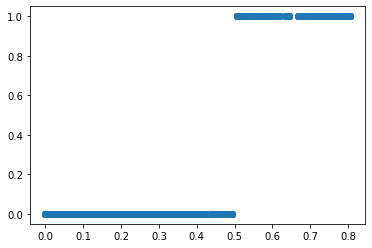

In [68]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.scatter(y_pred_proba, y_pred)

In [67]:
test.loc[X_test.index].customer_id

3311    4716-MRVEN
6330    8966-KZXXA
6156    8720-RQSBJ
5313    7504-UWHNB
1176    1730-VFMWO
           ...    
600     0877-SDMBN
3946    5555-RNPGT
3230    4628-CTTLA
349     0516-QREYC
3690    5198-HQAEN
Name: customer_id, Length: 1407, dtype: object

In [69]:
predictions = pd.DataFrame(data={'customer_id':test.loc[X_test.index].customer_id,
                                 'probability_of_churn':y_pred_proba,
                                 'prediction_of_churn':y_pred})

In [76]:
predictions.to_csv('predictions.csv', index=False)